In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [81]:
fold1_X_train = pd.read_csv('data/processed/fold_1_X_train.csv')
fold1_X_test = pd.read_csv('data/processed/fold_1_X_test.csv')  
fold1_y_train = pd.read_csv('data/processed/fold_1_y_train.csv').squeeze()
fold1_y_test = pd.read_csv('data/processed/fold_1_y_test.csv').squeeze()
fold2_X_train = pd.read_csv('data/processed/fold_2_X_train.csv')
fold2_X_test = pd.read_csv('data/processed/fold_2_X_test.csv')  
fold2_y_train = pd.read_csv('data/processed/fold_2_y_train.csv').squeeze()
fold2_y_test = pd.read_csv('data/processed/fold_2_y_test.csv').squeeze()

print("Ready for EDA")
print(f"  Data integrity verified: ✅")

Ready for EDA
  Data integrity verified: ✅


In [82]:
def explore_dataset(df, name="Dataset"):
    """
    Print basic information and statistics about a dataset (DataFrame).

    Parameters
    ----------
    df : pd.DataFrame
        The dataset to explore.
    name : str, optional
        Name of the dataset (default: "Dataset").
    """
    print(f"\n=== {name} ===")
    print("Shape:", df.shape)  # (rows, columns)
    print("Number of features:", df.shape[1])
    print("Number of samples:", df.shape[0])

    print("\n--- First 5 rows ---")
    print(df.head())

    print("\n--- Info ---")
    print(df.info())

    print("\n--- Statistics (numerical columns) ---")
    print(df.describe())

In [83]:
explore_dataset(fold1_X_train, name="Fold 1 X_train")
explore_dataset(fold2_X_train, name="Fold 2 X_train")


=== Fold 1 X_train ===
Shape: (8495, 7)
Number of features: 7
Number of samples: 8495

--- First 5 rows ---
   num__dewpoint_C  num__slp_hPa  num__wind_dir_deg  dt__dt__hour  \
0         1.851607     -0.126166          -1.077484      1.661774   
1         0.584922     -0.725202          -0.211985     -1.470698   
2         0.571154     -0.658642          -0.115819     -1.328313   
3         0.653764     -0.671954          -0.500485     -1.185928   
4         0.681301     -0.711890          -0.404318     -1.043543   

   dt__dt__dow  dt__dt__month  dt__dt__is_weekend  
0    -0.003822      -0.109919           -0.637905  
1    -1.002874       0.195531           -0.637905  
2    -1.002874       0.195531           -0.637905  
3    -1.002874       0.195531           -0.637905  
4    -1.002874       0.195531           -0.637905  

--- Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8495 entries, 0 to 8494
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dty

In [84]:
def quality_report(df, name="Dataset"):
    """
    Print a quick quality report: missing values, data types, duplicates.
    
    Parameters
    ----------
    df : pd.DataFrame
        The dataset to check.
    name : str, optional
        Name of the dataset (default: "Dataset").
    """
    print(f"\n=== Quality Report: {name} ===")
    
    # Missing values
    missing_data = df.isnull().sum()
    missing = missing_data[missing_data > 0]
    if not missing.empty:
        print("\nMissing values per column:")
        print(missing)
    else:
        print("\nNo missing values detected.")
    
    # Data types
    print("\nData types:")
    print(df.dtypes)
    
    # Duplicate rows
    duplicates = df.duplicated().sum()
    print(f"\nDuplicate rows: {duplicates}")

In [85]:
quality_report(fold1_X_train, name="Fold 1 X_train")
quality_report(fold2_X_train, name="Fold 2 X_train")


=== Quality Report: Fold 1 X_train ===

No missing values detected.

Data types:
num__dewpoint_C       float64
num__slp_hPa          float64
num__wind_dir_deg     float64
dt__dt__hour          float64
dt__dt__dow           float64
dt__dt__month         float64
dt__dt__is_weekend    float64
dtype: object

Duplicate rows: 2

=== Quality Report: Fold 2 X_train ===

No missing values detected.

Data types:
num__dewpoint_C       float64
num__slp_hPa          float64
num__wind_dir_deg     float64
dt__dt__hour          float64
dt__dt__dow           float64
dt__dt__month         float64
dt__dt__is_weekend    float64
dtype: object

Duplicate rows: 2


In [86]:
# Basic target statistics
print("Target Variable Analysis:")
print(f"Mean: {fold1_y_train.mean()}")
print(f"Median: {fold1_y_train.median()}")
print(f"Standard Deviation: {fold1_y_train.std()}")
print(f"Minimum: {fold1_y_train.min()}")
print(f"Maximum: {fold1_y_train.max()}")

# Check for missing values in target
print(f"Missing values: {fold1_y_train.isnull().sum()}")

Target Variable Analysis:
Mean: 40.90103673543967
Median: 36.55599346
Standard Deviation: 24.771881843953242
Minimum: 0.97232599
Maximum: 300.0
Missing values: 0


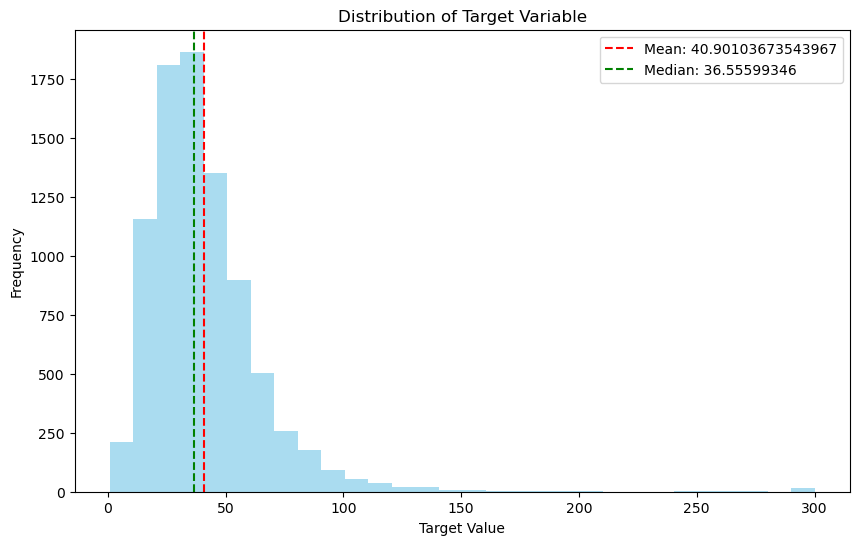

In [87]:
# Create a simple histogram
plt.figure(figsize=(10, 6))
plt.hist(fold1_y_train, bins=30, alpha=0.7, color='skyblue')
plt.axvline(fold1_y_train.mean(), color='red', linestyle='--', label=f'Mean: {fold1_y_train.mean()}')
plt.axvline(fold1_y_train.median(), color='green', linestyle='--', label=f'Median: {fold1_y_train.median()}')
plt.xlabel('Target Value')
plt.ylabel('Frequency')
plt.title('Distribution of Target Variable')
plt.legend()
plt.show()

count    8495.00
mean       40.90
std        24.77
min         0.97
25%        25.52
50%        36.56
75%        50.64
max       300.00
Name: target, dtype: float64


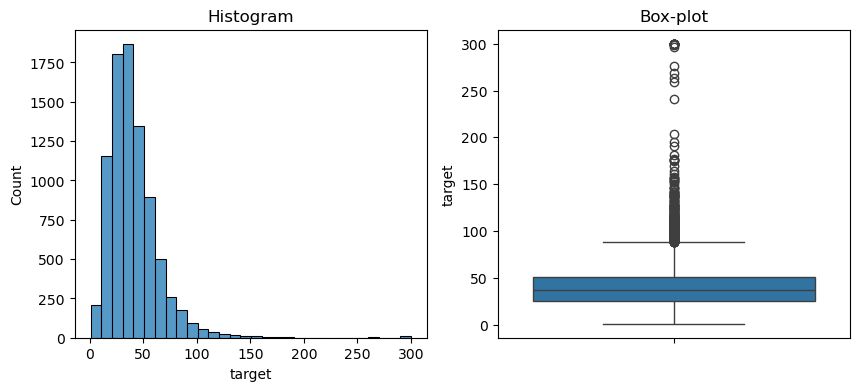

In [88]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
sns.histplot(fold1_y_train, ax=ax[0], bins=30); ax[0].set_title("Histogram")
sns.boxplot(fold1_y_train, ax=ax[1]);            ax[1].set_title("Box-plot")
print(fold1_y_train.describe().round(2))

Numeric stats:
                     mean  std   min   max
num__dewpoint_C      0.0  1.0 -3.39  2.35
num__slp_hPa         0.0  1.0 -2.87  3.03
num__wind_dir_deg   -0.0  1.0 -1.85  1.52
dt__dt__hour        -0.0  1.0 -1.61  1.66
dt__dt__dow         -0.0  1.0 -1.50  1.49
dt__dt__month       -0.0  1.0 -1.94  1.42
dt__dt__is_weekend  -0.0  1.0 -0.64  1.57


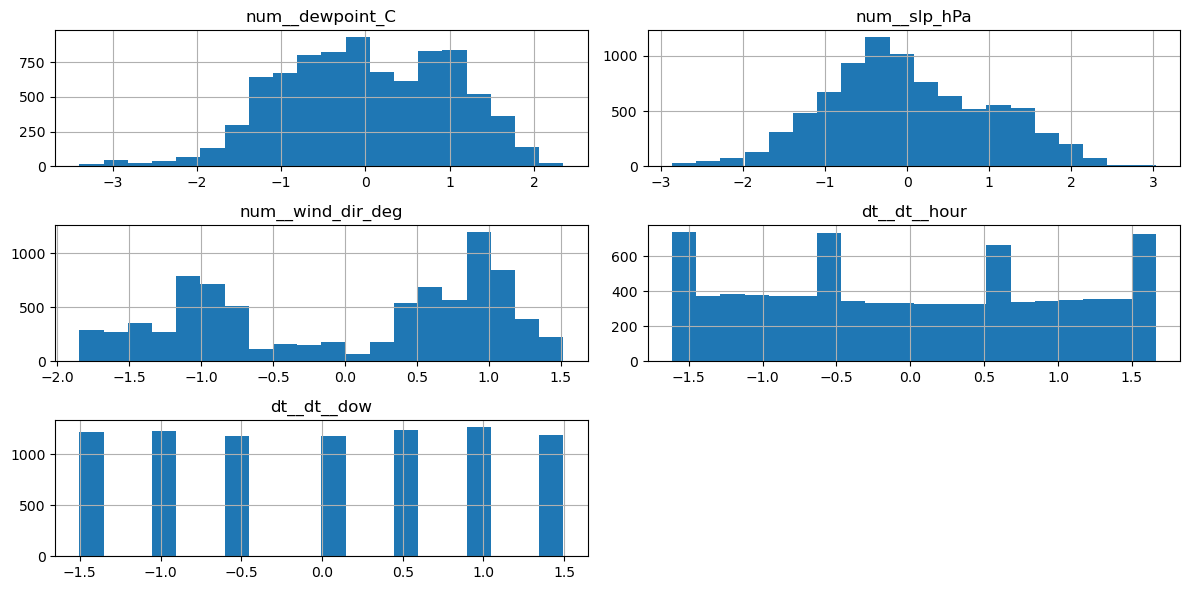

In [89]:
num_cols = fold1_X_train.select_dtypes('number').columns
print("Numeric stats:\n", fold1_X_train[num_cols].describe().T[['mean','std','min','max']].round(2))
# Plot first 4 histograms*
fold1_X_train[num_cols[:5]].hist(bins=20, figsize=(12,6))
plt.tight_layout()
plt.show()

Top correlations:
 dt__dt__hour          0.316
num__dewpoint_C      -0.204
num__slp_hPa          0.174
dt__dt__is_weekend   -0.157
dt__dt__dow          -0.105
num__wind_dir_deg    -0.073
dt__dt__month        -0.050
dtype: float64


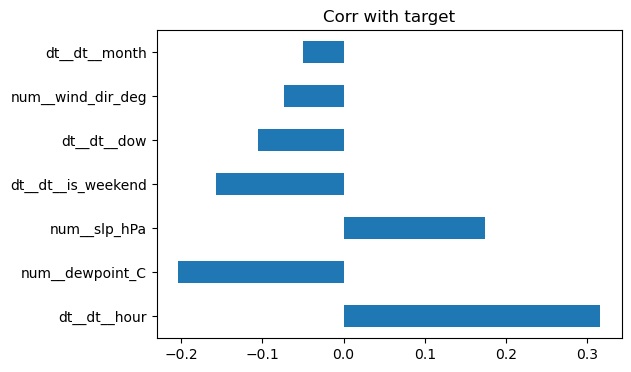

In [90]:
corrs = fold1_X_train[num_cols].corrwith(fold1_y_train).sort_values(key=abs, ascending=False)
print("Top correlations:\n", corrs.round(3))
corrs.plot.barh(figsize=(6,4)); plt.title("Corr with target"); plt.show()

In [91]:
def iqr_outliers(s):
    q1,q3=s.quantile([.25,.75]); iqr=q3-q1
    return s[(s<q1-1.5*iqr)|(s>q3+1.5*iqr)]
for col in num_cols[:]:
    outs = iqr_outliers(fold1_X_train[col])
    print(f"{col}: {len(outs)} outliers ({len(outs)/len(fold1_X_train)*100:.1f}%)")

num__dewpoint_C: 18 outliers (0.2%)
num__slp_hPa: 19 outliers (0.2%)
num__wind_dir_deg: 0 outliers (0.0%)
dt__dt__hour: 0 outliers (0.0%)
dt__dt__dow: 0 outliers (0.0%)
dt__dt__month: 0 outliers (0.0%)
dt__dt__is_weekend: 0 outliers (0.0%)


In [92]:
corr_mat = fold1_X_train[num_cols].corr().abs()
high_corr = np.where((corr_mat>0.8)&(corr_mat<1.0))
pairs = [(num_cols[i],num_cols[j],corr_mat.iat[i,j]) 
         for i,j in zip(*high_corr) if i<j]
print("High-corr pairs:", pairs[:5])

High-corr pairs: []


In [93]:
print("🚀 EDA SNAPSHOT")
print(f"Target skew: {fold1_y_train.skew():.2f}")
print("Strongest predictor:", corrs.index[0], corrs.max().round(3))
miss = (fold1_X_train.isnull().mean()*100).sort_values(ascending=False).head(3)
print("Top missing cols:\n", miss.round(1))
print("High-corr pairs:", pairs[:3])

🚀 EDA SNAPSHOT
Target skew: 3.32
Strongest predictor: dt__dt__hour 0.316
Top missing cols:
 num__dewpoint_C      0.0
num__slp_hPa         0.0
num__wind_dir_deg    0.0
dtype: float64
High-corr pairs: []
